In [ ]:
%pip install pandas scipy statsmodels matplotlib seaborn numpy openpyxl

In [1]:
import pandas as pd
import json
import scipy.stats as stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import util
import seaborn as sns
import matplotlib.pyplot as plt
import os


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Load data

In [2]:
# Create DataFrames for design config
with open('../task/design.json') as file:
    design_config = json.load(file)

stage_tasks_df = pd.DataFrame([
    {'stage': stage, 'task': task}
    for stage, stage_config in design_config['stages'].items()
    for task in stage_config['tasks']
])
group_stage_models_df = pd.DataFrame([
    {
        'group': group,
        'stage': stage,
        'model': model,
    }
    for group, group_config in design_config['groups'].items()
    for stage, model in group_config['models'].items()
])
group_task_model_df = group_stage_models_df.merge(stage_tasks_df, on='stage')[['group', 'task', 'model']]

In [3]:
# Load participants
participants_df = pd.read_csv('data/participants.csv')

In [4]:
# Load interactions
interactions_df = pd.read_csv('data/interactions.csv')
interactions_df['input_length'] = interactions_df['input'].str.len()
interactions_df['response_length'] = interactions_df['response'].str.len()
interactions_df = interactions_df.merge(participants_df[['participant_ID', 'group']], on=['participant_ID'])
interactions_df = interactions_df.merge(group_task_model_df, on=['group', 'task'])

In [5]:
# Load participant tasks
participant_tasks_df = pd.read_csv('data/tasks.csv', dtype=str)
participant_tasks_df['interaction_time'] = participant_tasks_df['interaction_time'].astype(int)
participant_tasks_df['quiz_time'] = participant_tasks_df['quiz_time'].astype(int)
participant_tasks_df = participant_tasks_df.merge(participants_df[['participant_ID', 'group']], on=['participant_ID'])
participant_tasks_df = participant_tasks_df.merge(group_task_model_df, on=['group', 'task'])

answers_checked_df = util.check_answers(participant_tasks_df)

In [6]:
# Load evaluations
evaluations_df = pd.read_csv('data/evaluations.csv')
evaluations_df = evaluations_df.merge(participants_df[['participant_ID', 'group']], on='participant_ID')
evaluations_df['model'] = evaluations_df.apply(lambda row: design_config['groups'][row['group']]['models'][row['chatbot']], axis=1)
evaluations_df = evaluations_df.merge(stage_tasks_df, left_on='chatbot', right_on='stage')

evaluations_df['usefulness'] = evaluations_df[[f'usefulness_{i + 1}' for i in range(6)]].mean(axis=1)
evaluations_df['ease_of_use'] = evaluations_df[[f'ease_of_use_{i + 1}' for i in range(6)]].mean(axis=1)
evaluations_df['cognitive_load'] = evaluations_df[[f'cognitive_load_{i + 1}' for i in range(6)]].mean(axis=1)

In [7]:
# Load coding data
LLM_programming_other_codes_df = util.load_codes('LLM_programming_other')
LLM_programming_feedback_codes_df = util.load_codes('LLM_programming_feedback')
speed_feedback_codes_df = util.load_codes('speed_feedback')
feedback_codes_df = util.load_codes('feedback', code_postfix='model')
input_codes_df = util.load_codes('inputs', additional_columns=['task', 'turn'])

In [8]:
# Confirm all data is present
print(f'Found {participants_df.shape[0]} participants')

participants_no_interaction = set()

for participant in participants_df['participant_ID'].unique():
    for stage in stage_tasks_df['stage'].unique():
        if not ((evaluations_df['participant_ID'] == participant) & (evaluations_df['chatbot'] == stage)).any():
            print(f"Missing evaluation for participant '{participant}' stage '{stage}'")

    for task in stage_tasks_df['task'].unique():
        if not ((interactions_df['participant_ID'] == participant) & (interactions_df['task'] == task)).any():
            print(f"Missing interaction for participant '{participant}' task '{task}'")
            participants_no_interaction.add(participant)

        if not ((participant_tasks_df['participant_ID'] == participant) & (participant_tasks_df['task'] == task)).any():
            print(f"Missing task data for participant '{participant}' task '{task}'")

print(f"Found {len(participants_no_interaction)} participants without interaction data for both tasks")

Found 14 participants
Missing interaction for participant 'P12' task 'natural-language-processing'
Found 1 participants without interaction data for both tasks


# Demographics

In [9]:
participants_df.describe()

,experience_programming,experience_programming_estimated,experience_oop,experience_python,experience_data_analysis,experience_nlp,familiarity_LLM,familiarity_LLM_programming_writing,familiarity_LLM_programming_modifying,familiarity_LLM_programming_debugging,familiarity_LLM_programming_explaining,familiarity_LLM_programming_learning
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,4.750000,5.714286,3.785714,5.357143,4.000000,2.142857,3.000000,2.357143,1.785714,1.928571,2.142857,2.142857
std,1.826619,1.938619,2.423557,2.340517,2.287087,2.413333,0.877058,1.081818,1.121714,1.268814,1.099450,1.231456
min,2.000000,2.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,5.000000,2.000000,4.000000,2.000000,1.000000,2.250000,2.000000,1.000000,1.000000,1.000000,1.000000
50%,4.750000,6.500000,2.500000,5.500000,3.000000,1.000000,3.000000,2.000000,1.000000,1.000000,2.000000,2.000000
75%,6.000000,7.000000,6.000000,7.000000,6.000000,1.750000,3.000000,2.750000,2.000000,2.750000,3.000000,2.750000
max,8.000000,8.000000,8.000000,9.000000,8.000000,9.000000,5.000000,5.000000,4.000000,4.000000,4.000000,5.000000


In [10]:
participants_df['study_programming_oriented'].value_counts(), participants_df['study_programming_oriented'].value_counts() / participants_df.shape[0] * 100, participants_df['study_stage'].value_counts(), participants_df['study_stage'].value_counts() / participants_df.shape[0] * 100

(study_programming_oriented
 True     7
 False    7
 Name: count, dtype: int64,
 study_programming_oriented
 True     50.0
 False    50.0
 Name: count, dtype: float64,
 study_stage
 M     8
 B3    4
 B2    2
 Name: count, dtype: int64,
 study_stage
 M     57.142857
 B3    28.571429
 B2    14.285714
 Name: count, dtype: float64)

# Interactions

In [11]:
# Interaction count and time per agent and task
interaction_stats_df = participant_tasks_df[['participant_ID', 'model', 'group', 'task', 'interaction_time']].merge(
    interactions_df.groupby(['participant_ID', 'model', 'group']).size().reset_index(name='n_interactions'),
    on=['participant_ID', 'model', 'group'],
    how='left'
)
interaction_stats_df['n_interactions'] = interaction_stats_df['n_interactions'].fillna(0)

compare = {
    'model': (stats.ttest_rel, ('control', 'tom')),
    'task': (stats.ttest_rel, ('natural-language-processing', 'data-analysis')),
}

print(interaction_stats_df.groupby('participant_ID').agg({
    'n_interactions': 'sum',
    'interaction_time': 'sum'
}).describe())

for column, (test, values) in compare.items():
    print(f'{column}:')

    for stat in ['n_interactions', 'interaction_time']:
        print(f'{stat}:')
        print(interaction_stats_df.groupby(column)[stat].describe())
        print(test(
            interaction_stats_df[
                (interaction_stats_df[column] == values[0])
            ][stat], 
            interaction_stats_df[
                (interaction_stats_df[column] == values[1])
            ][stat]
        ))

       n_interactions  interaction_time
count       14.000000         14.000000
mean        14.357143       1456.142857
std          7.821146        645.781203
min          2.000000        309.000000
25%          8.250000        956.250000
50%         14.000000       1505.000000
75%         21.250000       1836.750000
max         27.000000       2455.000000
model:
n_interactions:
         count      mean       std  min   25%  50%   75%   max
model                                                         
control   14.0  7.214286  4.560340  0.0  4.25  6.5  9.75  17.0
tom       14.0  7.142857  4.704452  2.0  4.00  5.5  8.50  17.0
TtestResult(statistic=0.053790238123084026, pvalue=0.9579201278402341, df=13)
interaction_time:
         count        mean         std    min     25%    50%     75%     max
model                                                                       
control   14.0  739.000000  363.664258  132.0  460.50  781.0  1045.5  1218.0
tom       14.0  717.142857  319.379894

In [12]:
# Generate LaTeX table for the user input codes
if not os.path.exists('figures'):
    os.makedirs('figures')
util.codes_latex_table(
    'figures/interaction_codes_approach_task.tex',
    interactions_df,
    ['participant_ID', 'task', 'turn'], 
    input_codes_df, 
    [
        {
            'column': 'model',
            'title': 'Approach',
            'options': [
                {'value': 'control', 'title': 'Control'},
                {'value': 'tom', 'title': '\\approach{}'},
            ]
        }, 
        {
            'column': 'task',
            'title': 'Task',
            'options': [
                {'value': 'natural-language-processing', 'title': 'Task 1'},
                {'value': 'data-analysis', 'title': 'Task 2'},
            ]
        }, 
    ]
)

In [13]:
# Cluster participants based on if they use hypotheses or not
participant_IDs_hypotheses = input_codes_df[input_codes_df['code'] == 'question:hypothesis']['participant_ID'].unique()
hypotheses_stats_df = participants_df
hypotheses_stats_df['uses_hypotheses'] = hypotheses_stats_df['participant_ID'].isin(participant_IDs_hypotheses)
hypotheses_stats_df = hypotheses_stats_df.merge(
    interaction_stats_df.groupby('participant_ID').agg({
        'n_interactions': 'sum',
        'interaction_time': 'sum'
    }).reset_index(),
    on='participant_ID'
)

for stat, test in {
   'experience_programming': stats.ttest_ind, 
   'familiarity_LLM': stats.ttest_ind, 
   'study_programming_oriented': lambda a, b: stats.fisher_exact([
       [sum(~a), sum(a)],
       [sum(~b), sum(b)],
   ]), 
   'n_interactions': stats.ttest_ind, 
   'interaction_time': stats.ttest_ind
}.items():
    print(f'{stat}:')
    print(hypotheses_stats_df.groupby('uses_hypotheses')[stat].describe())
    print(test(
        hypotheses_stats_df[hypotheses_stats_df['uses_hypotheses']][stat], 
        hypotheses_stats_df[~hypotheses_stats_df['uses_hypotheses']][stat]
    ))

experience_programming:
                 count      mean       std  min    25%   50%    75%  max
uses_hypotheses                                                         
False              8.0  4.812500  1.944544  2.5  3.000  4.75  6.125  8.0
True               6.0  4.666667  1.834848  2.0  3.375  5.25  6.000  6.5
TtestResult(statistic=-0.14215090559511265, pvalue=0.8893195601554469, df=12.0)
familiarity_LLM:
                 count      mean       std  min  25%  50%   75%  max
uses_hypotheses                                                     
False              8.0  2.875000  0.834523  2.0  2.0  3.0  3.25  4.0
True               6.0  3.166667  0.983192  2.0  3.0  3.0  3.00  5.0
TtestResult(statistic=0.6004290311595761, pvalue=0.5593896054980889, df=12.0)
study_programming_oriented:
                count unique    top freq
uses_hypotheses                         
False               8      2  False    5
True                6      2   True    4
SignificanceResult(statistic=0.3, pvalue=

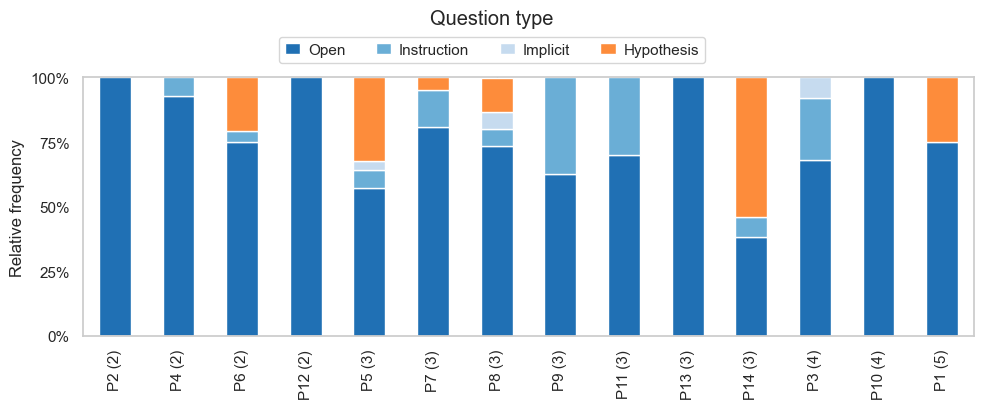

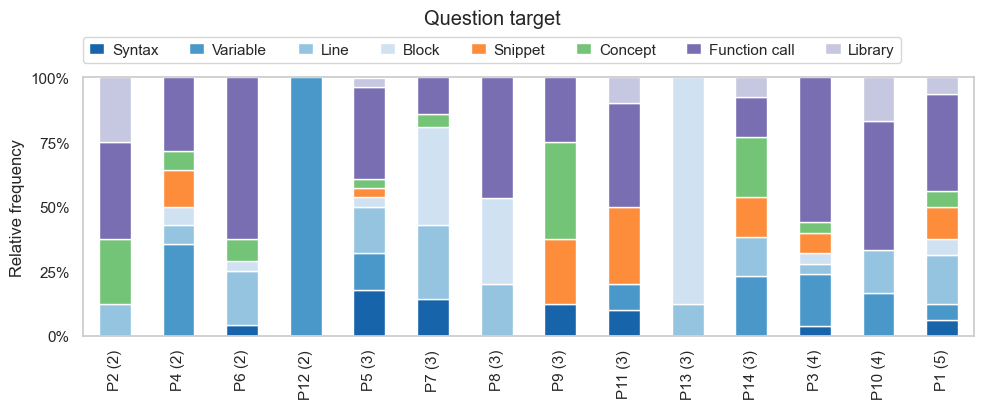

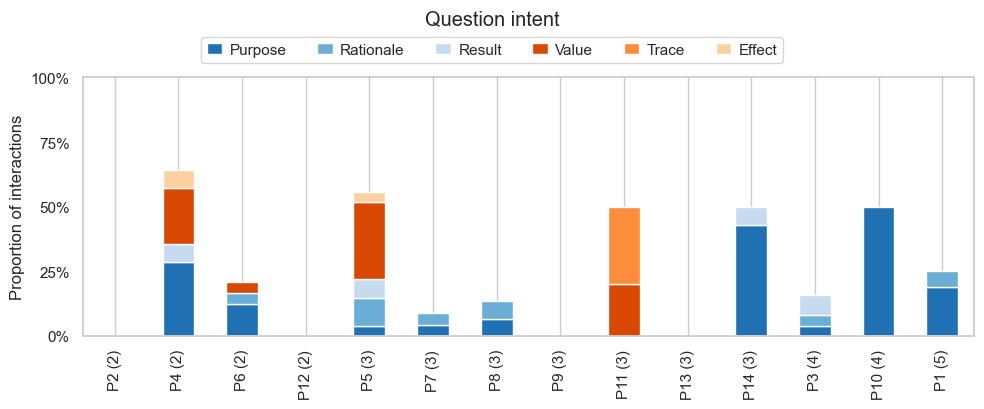

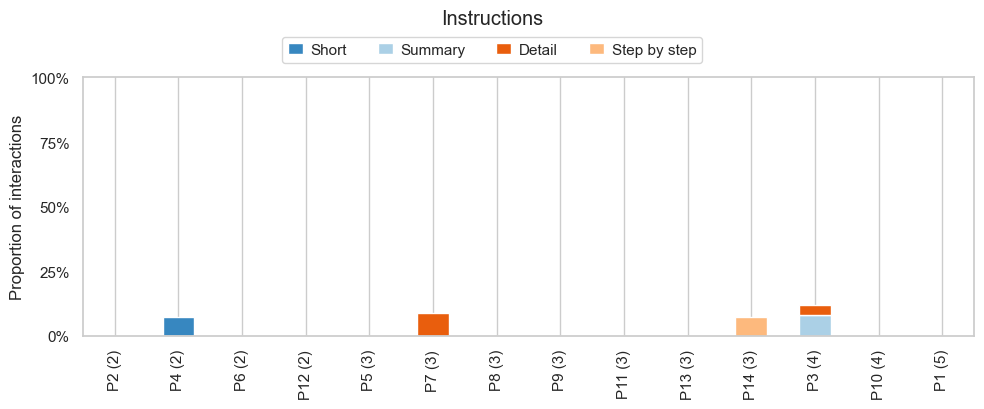

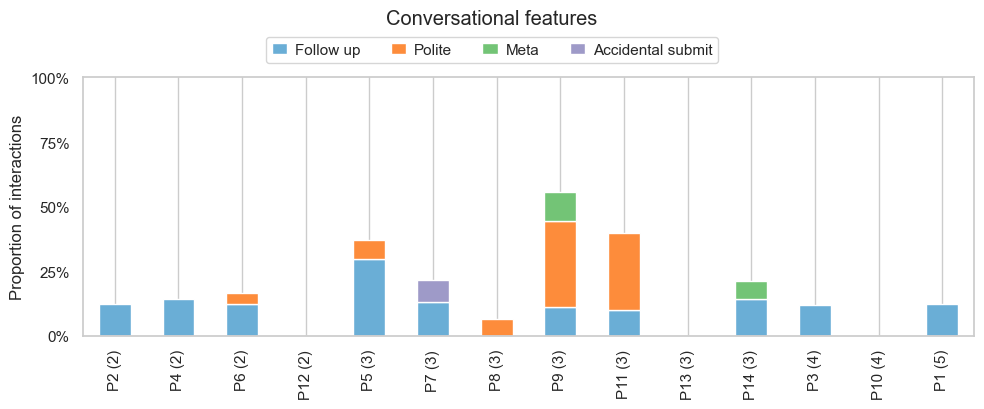

In [14]:
# How are question / intent / instruction / conversational feature codes distributed per participant, sorted by LLM familiarity?
util.plot_codes_bars(
    'figures/interaction_codes_LLM_familiarity',
    hypotheses_stats_df,
    util.codes_count(
        interactions_df,
        ['participant_ID', 'task', 'turn'],
        input_codes_df,
        ['participant_ID']
    ),
    categories=[
        {
            'title': 'Question type',
            'code': 'question', 
            'stat': 'frequency_parent',
            'label': 'Relative frequency',
            'groups': [
                ['open', 'instruction', 'implicit'],
                ['hypothesis'],
            ]
        },
        {
            'title': 'Question target',
            'code': 'target', 
            'stat': 'frequency_parent',
            'label': 'Relative frequency',
            'groups': [
                ['syntax', 'variable', 'line', 'block'],
                ['snippet'],
                ['concept'],
                ['function_call', 'library'],
            ]
        },
        {
            'title': 'Question intent',
            'code': 'intent', 
            'stat': 'frequency_unique',
            'label': 'Proportion of interactions',
            'groups': [
                ['purpose', 'rationale', 'result'],
                ['value', 'trace', 'effect'],
            ]
        },
        {
            'title': 'Instructions',
            'code': 'instruction', 
            'stat': 'frequency_unique',
            'label': 'Proportion of interactions',
            'groups': [
                ['short', 'summary'],
                ['detail', 'step_by_step'],
            ],
        },
        {
            'title': 'Conversational features',
            'code': 'conversation', 
            'stat': 'frequency_unique',
            'label': 'Proportion of interactions',
            'groups': [
                ['follow_up'],
                ['polite'],
                ['meta'],
                ['accidental_submit'],
            ],
        },
    ],
    index_order=participants_df.sort_values('familiarity_LLM')['participant_ID'].to_list(),
    index_labels={row['participant_ID']: f"{row['participant_ID']} ({row['familiarity_LLM']})" for _, row in participants_df.iterrows()},
)

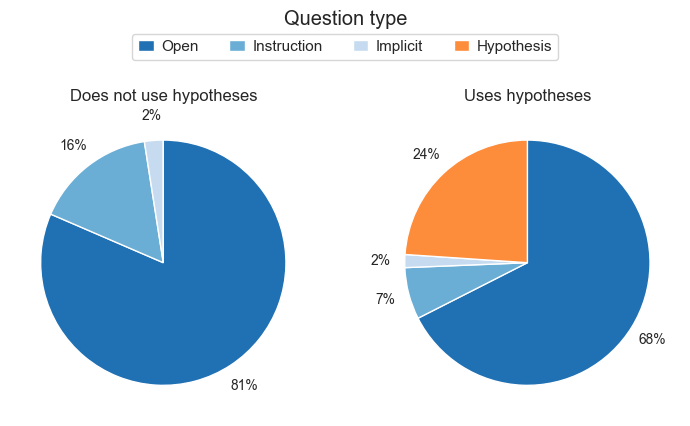

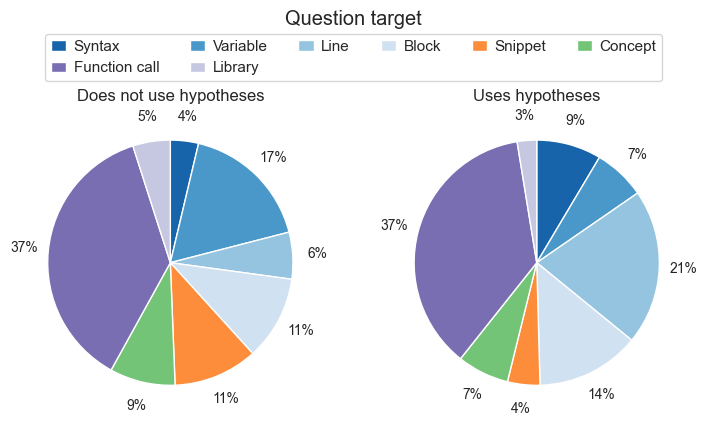

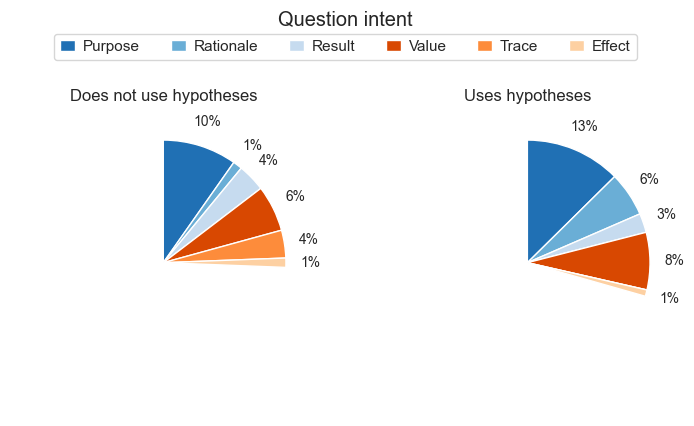

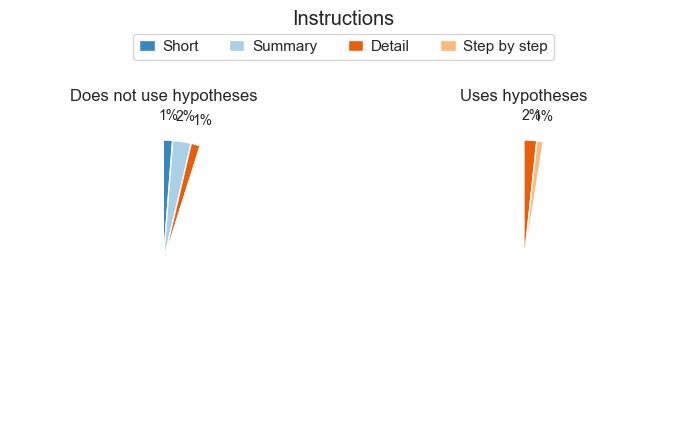

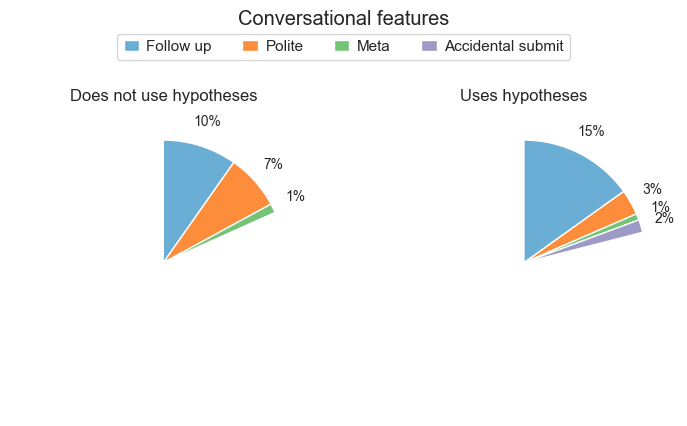

In [15]:
items_df = interactions_df.copy()
items_df['uses_hypotheses'] = items_df['participant_ID'].isin(participant_IDs_hypotheses)
codes_count_df = util.codes_count(
    items_df,
    ['participant_ID', 'task', 'turn'],
    input_codes_df,
    ['uses_hypotheses']
)
util.plot_codes_pie(
    'figures/interaction_codes_hypotheses', codes_count_df, 
    [
        {
            'title': 'Question type',
            'code': 'question', 
            'stat': 'frequency_parent',
            'label': 'Relative frequency',
            'groups': [
                ['open', 'instruction', 'implicit'],
                ['hypothesis'],
            ]
        },
        {
            'title': 'Question target',
            'code': 'target', 
            'stat': 'frequency_parent',
            'label': 'Relative frequency',
            'groups': [
                ['syntax', 'variable', 'line', 'block'],
                ['snippet'],
                ['concept'],
                ['function_call', 'library'],
            ]
        },
        {
            'title': 'Question intent',
            'code': 'intent', 
            'stat': 'frequency_unique',
            'label': 'Proportion of interactions',
            'groups': [
                ['purpose', 'rationale', 'result'],
                ['value', 'trace', 'effect'],
            ]
        },
        {
            'title': 'Instructions',
            'code': 'instruction', 
            'stat': 'frequency_unique',
            'label': 'Proportion of interactions',
            'groups': [
                ['short', 'summary'],
                ['detail', 'step_by_step'],
            ],
        },
        {
            'title': 'Conversational features',
            'code': 'conversation', 
            'stat': 'frequency_unique',
            'label': 'Proportion of interactions',
            'groups': [
                ['follow_up'],
                ['polite'],
                ['meta'],
                ['accidental_submit'],
            ],
        },
    ], 
    [
        {
            'title': 'Does not use hypotheses',
            'column': 'uses_hypotheses',
            'value': False
        },
        {
            'title': 'Uses hypotheses',
            'column': 'uses_hypotheses',
            'value': True
        },
    ]
)

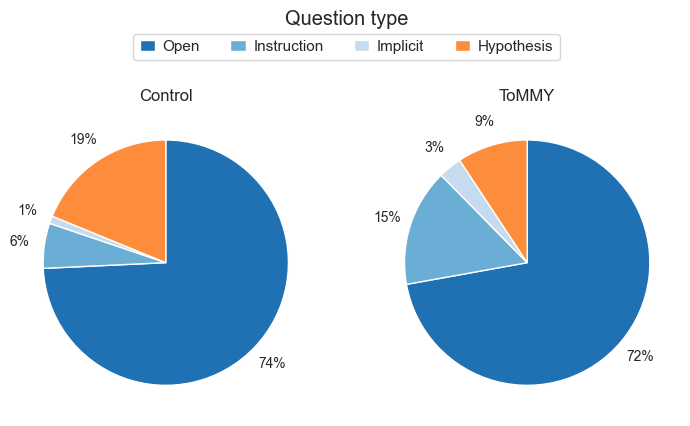

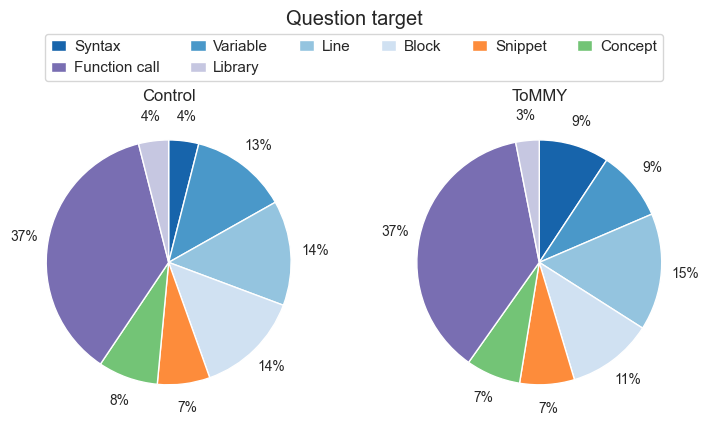

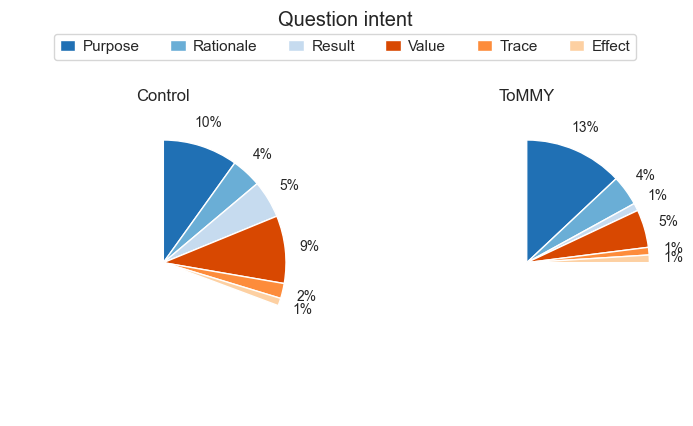

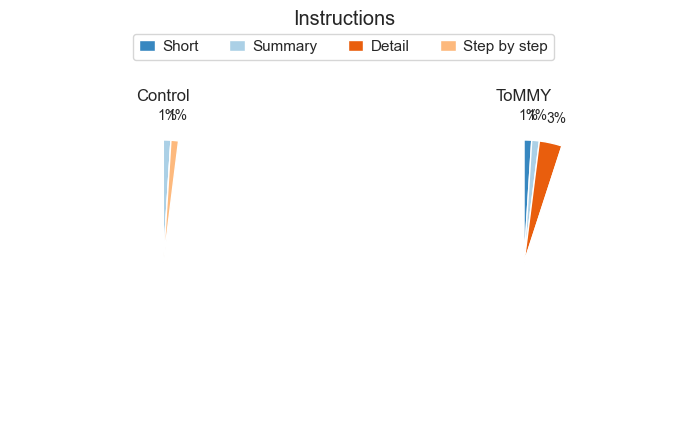

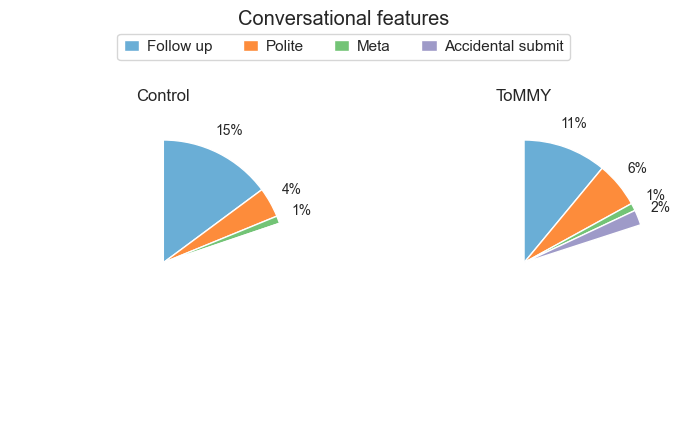

In [16]:
codes_count_df = util.codes_count(
    interactions_df,
    ['participant_ID', 'task', 'turn'],
    input_codes_df,
    ['model']
)
util.plot_codes_pie(
    'figures/interaction_codes_model', codes_count_df, 
    [
        {
            'title': 'Question type',
            'code': 'question', 
            'stat': 'frequency_parent',
            'label': 'Relative frequency',
            'groups': [
                ['open', 'instruction', 'implicit'],
                ['hypothesis'],
            ]
        },
        {
            'title': 'Question target',
            'code': 'target', 
            'stat': 'frequency_parent',
            'label': 'Relative frequency',
            'groups': [
                ['syntax', 'variable', 'line', 'block'],
                ['snippet'],
                ['concept'],
                ['function_call', 'library'],
            ]
        },
        {
            'title': 'Question intent',
            'code': 'intent', 
            'stat': 'frequency_unique',
            'label': 'Proportion of interactions',
            'groups': [
                ['purpose', 'rationale', 'result'],
                ['value', 'trace', 'effect'],
            ]
        },
        {
            'title': 'Instructions',
            'code': 'instruction', 
            'stat': 'frequency_unique',
            'label': 'Proportion of interactions',
            'groups': [
                ['short', 'summary'],
                ['detail', 'step_by_step'],
            ],
        },
        {
            'title': 'Conversational features',
            'code': 'conversation', 
            'stat': 'frequency_unique',
            'label': 'Proportion of interactions',
            'groups': [
                ['follow_up'],
                ['polite'],
                ['meta'],
                ['accidental_submit'],
            ],
        },
    ], 
    [
        {
            'title': 'Control',
            'column': 'model',
            'value': 'control'
        },
        {
            'title': 'ToMMY',
            'column': 'model',
            'value': 'tom'
        },
    ]
)

In [17]:
# Frequencies of code categories for each participant cluster
items_df = interactions_df.copy()
items_df['uses_hypotheses'] = items_df['participant_ID'].isin(participant_IDs_hypotheses)
codes_count_df = util.codes_count(
    items_df,
    ['participant_ID', 'task', 'turn'],
    input_codes_df,
    ['uses_hypotheses']
)
codes_count_df[codes_count_df['code_level_2'].isna()]

,count,uses_hypotheses_True_count,uses_hypotheses_False_count,code_level_1,frequency_parent,count_unique,frequency_unique,uses_hypotheses_True_frequency_parent,uses_hypotheses_True_count_unique,uses_hypotheses_True_frequency_unique,uses_hypotheses_False_frequency_parent,uses_hypotheses_False_count_unique,uses_hypotheses_False_frequency_unique,code_level_2
0,201,119.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,198,117.0,81.0,question,0.396794,197.0,0.980100,0.393939,116.0,0.974790,0.400990,81.0,0.987805,NaN
6,198,117.0,81.0,target,0.396794,197.0,0.980100,0.393939,116.0,0.974790,0.400990,81.0,0.987805,NaN
15,56,35.0,21.0,intent,0.112224,55.0,0.273632,0.117845,34.0,0.285714,0.103960,21.0,0.256098,NaN
22,40,25.0,15.0,conversation,0.080160,40.0,0.199005,0.084175,25.0,0.210084,0.074257,15.0,0.182927,NaN
27,7,3.0,4.0,instruction,0.014028,7.0,0.034826,0.010101,3.0,0.025210,0.019802,4.0,0.048780,NaN


# Code understanding

In [18]:
# Merge data for regression
performance_df = participant_tasks_df.merge(
    participants_df,
    on='participant_ID'
).merge(
    answers_checked_df.groupby(['participant_ID', 'task']).agg(n_correct=('correct', 'sum')).reset_index(),
    on=['participant_ID', 'task']
)

performance_df['uses_hypotheses'] = performance_df['participant_ID'].isin(participant_IDs_hypotheses)

performance_df['uses_tom'] = performance_df['model'] == 'tom'
performance_df['experience_domain'] = performance_df.apply(lambda row: row['experience_data_analysis'] if row['task'] == 'data-analysis' else row['experience_nlp'], axis=1)

In [19]:
# Ensure no colinearity (scores should be <2.5)
from statsmodels.stats.outliers_influence import variance_inflation_factor

exog = sm.tools.add_constant(performance_df[[
    'experience_programming', 
    'experience_domain', 
    'familiarity_LLM', 
    'uses_tom', 
    'uses_hypotheses',
]])
exog['uses_tom'] = exog['uses_tom'].astype(int)
exog['uses_hypotheses'] = exog['uses_hypotheses'].astype(int)
for i, column in enumerate(exog.columns):
    print(f'{column}: {variance_inflation_factor(exog.values, i)}')

const: 26.484293893719983
experience_programming: 1.0195186225037134
experience_domain: 1.0948930406928774
familiarity_LLM: 1.04696076838204
uses_tom: 1.0009318238644196
uses_hypotheses: 1.0949462927593288


In [20]:
# Regression on quiz performance, with heteroskedasticity-robust standard errors to account for underdispersion
mod = smf.glm(formula='n_correct ~ uses_tom + experience_programming_estimated + experience_domain + familiarity_LLM', data=performance_df, family=sm.families.Poisson())
res = mod.fit(cov_type='HC0')
print(f'Dispersion: {res.pearson_chi2 / res.df_resid}')
res.summary()

Dispersion: 0.3639533148683744


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              n_correct   No. Observations:                   28
Model:                            GLM   Df Residuals:                       23
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -50.798
Date:                Fri, 28 Jun 2024   Deviance:                       9.3317
Time:                        21:18:23   Pearson chi2:                     8.37
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1465
Covariance Type:                  HC0                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.1857      0.273      4.337      0.000       0.650       1.722
uses_tom[T.True]                     0.0526      0.102      0.516      0.606      -0.147       0.253
experience_programming_estimated     0.0992      0.033      2.987      0.003       0.034       0.164
experience_domain                   -0.0108      0.029     -0.370      0.711      -0.068       0.046
familiarity_LLM                     -0.0948      0.039     -2.426      0.015      -0.171      -0.018
====================================================================================================
"""

In [21]:
# Regression on quiz time
mod = smf.glm(formula='quiz_time ~ uses_tom + experience_programming + experience_domain + familiarity_LLM', data=performance_df)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              quiz_time   No. Observations:                   28
Model:                            GLM   Df Residuals:                       23
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                          13077.
Method:                          IRLS   Log-Likelihood:                -169.68
Date:                Fri, 28 Jun 2024   Deviance:                   3.0077e+05
Time:                        21:18:23   Pearson chi2:                 3.01e+05
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4445
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                593.1508    110.156      5.385      0.000     377.249     809.052
uses_tom[T.True]         -28.9396     43.241     -0.669      0.503    -113.690      55.811
experience_programming   -39.3783     12.397     -3.176      0.001     -63.676     -15.081
experience_domain         -9.4231      8.961     -1.052      0.293     -26.985       8.139
familiarity_LLM           36.0551     25.905      1.392      0.164     -14.717      86.828
==========================================================================================
"""

In [22]:
# Regression on quiz performance, for participants with hypotheses
mod = smf.glm(formula='n_correct ~ uses_tom + experience_programming_estimated + experience_domain + familiarity_LLM', data=performance_df[performance_df['uses_hypotheses']], family=sm.families.Poisson())
res = mod.fit(cov_type='HC0')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              n_correct   No. Observations:                   12
Model:                            GLM   Df Residuals:                        7
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21.100
Date:                Fri, 28 Jun 2024   Deviance:                       3.4670
Time:                        21:18:23   Pearson chi2:                     3.35
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1929
Covariance Type:                  HC0                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            1.6550      0.364      4.542      0.000       0.941       2.369
uses_tom[T.True]                    -0.2821      0.156     -1.805      0.071      -0.588       0.024
experience_programming_estimated     0.0624      0.032      1.945      0.052      -0.000       0.125
experience_domain                    0.0074      0.030      0.250      0.802      -0.051       0.066
familiarity_LLM                     -0.1526      0.091     -1.678      0.093      -0.331       0.026
====================================================================================================
"""

In [23]:
# Regression on quiz performance, for participants without hypotheses
mod = smf.glm(formula='n_correct ~ uses_tom + experience_programming_estimated + experience_domain + familiarity_LLM', data=performance_df[~performance_df['uses_hypotheses']], family=sm.families.Poisson())
res = mod.fit(cov_type='HC0')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              n_correct   No. Observations:                   16
Model:                            GLM   Df Residuals:                       11
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27.969
Date:                Fri, 28 Jun 2024   Deviance:                       2.4078
Time:                        21:18:24   Pearson chi2:                     2.29
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2620
Covariance Type:                  HC0                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            0.9292      0.280      3.319      0.001       0.381       1.478
uses_tom[T.True]                     0.3368      0.105      3.220      0.001       0.132       0.542
experience_programming_estimated     0.1235      0.038      3.256      0.001       0.049       0.198
experience_domain                   -0.0473      0.027     -1.739      0.082      -0.101       0.006
familiarity_LLM                     -0.0600      0.043     -1.383      0.167      -0.145       0.025
====================================================================================================
"""

In [24]:
# What scores per task?
n_correct_task_df = performance_df.pivot(index='participant_ID', columns='task', values='n_correct').reset_index()
a = n_correct_task_df['data-analysis']
b = n_correct_task_df['natural-language-processing']
{
    'shapiro': stats.shapiro(a - b),
    'a': a.describe(),
    'b': b.describe(),
    'test': stats.ttest_rel(a, b)
}

{'shapiro': ShapiroResult(statistic=0.9489738007900742, pvalue=0.5448897033626207),
 'a': count    14.000000
 mean      4.714286
 std       1.204388
 min       3.000000
 25%       4.000000
 50%       5.000000
 75%       6.000000
 max       6.000000
 Name: data-analysis, dtype: float64,
 'b': count    14.000000
 mean      4.071429
 std       1.591530
 min       1.000000
 25%       3.000000
 50%       4.000000
 75%       5.750000
 max       6.000000
 Name: natural-language-processing, dtype: float64,
 'test': TtestResult(statistic=1.2362450755382013, pvalue=0.23823863912199592, df=13)}

In [25]:
# What quiz times per task?
quiz_time_task_df = performance_df.pivot(index='participant_ID', columns='task', values='quiz_time').reset_index()
a = quiz_time_task_df['data-analysis']
b = quiz_time_task_df['natural-language-processing']
{
    'shapiro': stats.shapiro(a - b),
    'a': a.describe(),
    'b': b.describe(),
    'test': stats.ttest_rel(a, b)
}

{'shapiro': ShapiroResult(statistic=0.9119634840919512, pvalue=0.1682753357955269),
 'a': count     14.000000
 mean     438.785714
 std      128.829153
 min      204.000000
 25%      364.750000
 50%      396.000000
 75%      535.000000
 max      626.000000
 Name: data-analysis, dtype: float64,
 'b': count     14.000000
 mean     502.928571
 std      142.735077
 min      256.000000
 25%      380.250000
 50%      572.000000
 75%      604.000000
 max      629.000000
 Name: natural-language-processing, dtype: float64,
 'test': TtestResult(statistic=-1.8245783191962675, pvalue=0.09112361215533892, df=13)}

# Perceptions

In [26]:
# How often do participants use LLMs for programming tasks?
participants_df[[
    'familiarity_LLM',
    'familiarity_LLM_programming_writing',
    'familiarity_LLM_programming_modifying',
    'familiarity_LLM_programming_debugging',
    'familiarity_LLM_programming_explaining',
    'familiarity_LLM_programming_learning'
]].describe()

,familiarity_LLM,familiarity_LLM_programming_writing,familiarity_LLM_programming_modifying,familiarity_LLM_programming_debugging,familiarity_LLM_programming_explaining,familiarity_LLM_programming_learning
count,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,3.000000,2.357143,1.785714,1.928571,2.142857,2.142857
std,0.877058,1.081818,1.121714,1.268814,1.099450,1.231456
min,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.250000,2.000000,1.000000,1.000000,1.000000,1.000000
50%,3.000000,2.000000,1.000000,1.000000,2.000000,2.000000
75%,3.000000,2.750000,2.000000,2.750000,3.000000,2.750000
max,5.000000,5.000000,4.000000,4.000000,4.000000,5.000000


In [27]:
# What other programming tasks do participants use LLMs for?
LLM_programming_other_codes_df['code'].value_counts()

code
none                  6
check_logic           1
evaluate_structure    1
not_write_code        1
explain_concepts      1
Name: count, dtype: int64

In [28]:
# What feedback do participants provide on LLMs for programming tasks?
util.codes_latex_table(
    'figures/LLM_programming_feedback_codes.tex',
    participants_df,
    ['participant_ID'],
    LLM_programming_feedback_codes_df,
)

In [29]:
# Perception metrics per agent
comparison_df = evaluations_df[~evaluations_df['participant_ID'].isin(participants_no_interaction)]
group = 'model'
a = 'control'
b = 'tom'
results = {}

for metric in ['usefulness', 'ease_of_use', 'cognitive_load'] + [f'cognitive_load_{i+1}' for i in range(6)]:
    a_values = comparison_df[comparison_df[group] == a][metric].reset_index(drop=True)
    b_values = comparison_df[comparison_df[group] == b][metric].reset_index(drop=True)
    results[metric] = {
        a: a_values.describe(),
        b: b_values.describe(),
        'test': stats.ttest_rel(a_values, b_values)
    }
results

{'usefulness': {'control': count    13.000000
  mean      6.179487
  std       0.759086
  min       5.000000
  25%       5.833333
  50%       6.000000
  75%       6.833333
  max       7.000000
  Name: usefulness, dtype: float64,
  'tom': count    13.000000
  mean      6.089744
  std       0.759555
  min       4.666667
  25%       5.500000
  50%       6.333333
  75%       6.666667
  max       7.000000
  Name: usefulness, dtype: float64,
  'test': TtestResult(statistic=0.5329708913388161, pvalue=0.6037841256507341, df=12)},
 'ease_of_use': {'control': count    13.000000
  mean      6.269231
  std       0.731369
  min       4.666667
  25%       5.833333
  50%       6.666667
  75%       6.833333
  max       7.000000
  Name: ease_of_use, dtype: float64,
  'tom': count    13.000000
  mean      6.051282
  std       0.967970
  min       3.333333
  25%       6.000000
  50%       6.333333
  75%       6.666667
  max       7.000000
  Name: ease_of_use, dtype: float64,
  'test': TtestResult(statist

In [30]:
# Perception metrics per agent
comparison_df = evaluations_df
group = 'task'
a = 'natural-language-processing'
b = 'data-analysis'
results = {}

for metric in ['cognitive_load'] + [f'cognitive_load_{i+1}' for i in range(6)]:
    a_values = comparison_df[comparison_df[group] == a][metric].reset_index(drop=True)
    b_values = comparison_df[comparison_df[group] == b][metric].reset_index(drop=True)
    results[metric] = {
        a: a_values.describe(),
        b: b_values.describe(),
        'test': stats.ttest_rel(a_values, b_values)
    }
results

{'cognitive_load': {'natural-language-processing': count    14.000000
  mean      0.321429
  std       2.481095
  min      -4.666667
  25%      -1.625000
  50%       0.916667
  75%       2.500000
  max       3.333333
  Name: cognitive_load, dtype: float64,
  'data-analysis': count    14.000000
  mean      0.773810
  std       1.738954
  min      -1.333333
  25%      -0.708333
  50%       0.833333
  75%       1.916667
  max       4.166667
  Name: cognitive_load, dtype: float64,
  'test': TtestResult(statistic=-1.1505808921065381, pvalue=0.27062964309625326, df=13)},
 'cognitive_load_1': {'natural-language-processing': count    14.000000
  mean      3.928571
  std       3.384678
  min      -5.000000
  25%       3.000000
  50%       4.500000
  75%       6.000000
  max       8.000000
  Name: cognitive_load_1, dtype: float64,
  'data-analysis': count    14.000000
  mean      4.642857
  std       2.898465
  min      -3.000000
  25%       3.250000
  50%       5.500000
  75%       6.750000
  m

In [31]:
# Generate LaTeX table for the user feedback codes
util.codes_latex_table(
    'figures/feedback_codes.tex',
    evaluations_df,
    ['participant_ID', 'model'], 
    feedback_codes_df, 
    [
        {
            'column': 'model',
            'title': 'Approach',
            'options': [
                {'value': 'control', 'title': 'Control'},
                {'value': 'tom', 'title': '\\approach{}'},
            ]
        },
    ]
)

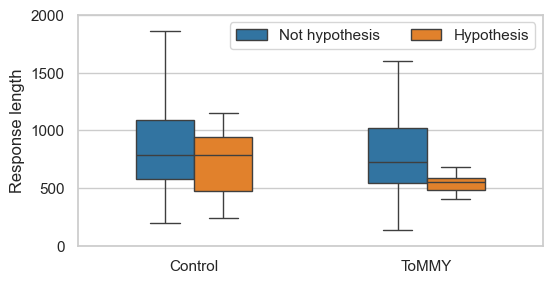

In [32]:
# How do response lengths differ for hypotheses, per model?
interactions_hypotheses_df = input_codes_df[input_codes_df['code'] == 'question:hypothesis'].copy()
interactions_hypotheses_df['is_hypothesis'] = True
interactions_hypotheses_df = interactions_hypotheses_df[['participant_ID', 'task', 'turn', 'is_hypothesis']].merge(
    interactions_df,
    how='right',
    on=['participant_ID', 'task', 'turn']
)
with pd.option_context("future.no_silent_downcasting", True):
    interactions_hypotheses_df['is_hypothesis'] = interactions_hypotheses_df['is_hypothesis'].fillna(False).infer_objects(copy=False)
plt.figure(figsize=(6, 3))
ax = sns.boxplot(x='model', hue='is_hypothesis', y='response_length', data=interactions_hypotheses_df, width=0.5, palette='tab10', showfliers=False, )
ax.set_xticks(['control', 'tom'])
ax.set_xticklabels(['Control', 'ToMMY'])
ax.set_ylabel('Response length')
ax.legend(ncol=2).set_title(None)
ax.legend_.texts[0].set_text('Not hypothesis')
ax.legend_.texts[1].set_text('Hypothesis')

ax.set_xlabel(None)
ax.set_ylim(0, 2000)
plt.savefig('figures/response_length_model.png', bbox_inches='tight')

In [33]:
# How is ToMMY's response speed perceived?
evaluations_df[
    ~evaluations_df['participant_ID'].isin(participants_no_interaction)
].apply(lambda row: row['relative_speed'] if row['model'] == 'tom' else 5 - row['relative_speed'] + 1, axis=1).describe()

count    13.000000
mean      2.461538
std       0.660225
min       2.000000
25%       2.000000
50%       2.000000
75%       3.000000
max       4.000000
dtype: float64

In [34]:
# How does the agents' response speed affect perceptions?
speed_feedback_codes_df['code'].value_counts()

code
not_significant            13
read_while_loading          3
tom_first_slow              2
tom_time_shortage           2
both_fast                   2
changed_strategy            1
control_fast                1
response_more_important     1
not_read_while_loading      1
Name: count, dtype: int64